Si ModuleNotFoundError: No module named 'tqdm' faire !pip install tqdm dans une cellule code

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import joblib
from tqdm import tqdm


In [2]:
TRAIN_PATH = "../dataset/seg_train"
TEST_PATH  = "../dataset/seg_test"

In [3]:
MAX_FEATURES = 1500   # ORB keypoints
K = 300               # taille du vocabulaire visuel

In [4]:
def load_images(folder_path):
    image_paths = []
    labels = []
    class_names = sorted(os.listdir(folder_path))

    for label, class_name in enumerate(class_names):
        class_path = os.path.join(folder_path, class_name)
        for img in os.listdir(class_path):
            image_paths.append(os.path.join(class_path, img))
            labels.append(label)

    return image_paths, labels, class_names


train_paths, train_labels, class_names = load_images(TRAIN_PATH)
test_paths, test_labels, _ = load_images(TEST_PATH)

print("Classes :", class_names)
print("Train :", len(train_paths))
print("Test :", len(test_paths))


Classes : ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Train : 14034
Test : 3000


In [5]:
orb = cv2.ORB_create(
    nfeatures=MAX_FEATURES,
    scaleFactor=1.2,
    nlevels=8
)

In [6]:
def extract_orb(paths, labels):
    descriptors = []
    valid_labels = []

    for path, label in tqdm(zip(paths, labels), total=len(paths)):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        kp, des = orb.detectAndCompute(img, None)
        if des is not None:
            descriptors.append(des)
            valid_labels.append(label)

    return descriptors, np.array(valid_labels)


train_des, y_train = extract_orb(train_paths, train_labels)

100%|██████████| 14034/14034 [00:13<00:00, 1050.54it/s]


In [7]:
test_des, y_test = extract_orb(test_paths, test_labels)

print("Descripteurs test :", len(test_des))

100%|██████████| 3000/3000 [00:02<00:00, 1079.77it/s]

Descripteurs test : 2997


In [8]:
all_train_des = np.vstack(train_des)

kmeans = MiniBatchKMeans(
    n_clusters=K,
    batch_size=2000,   # plus gros batch
    random_state=42,
    n_init=10
)

kmeans.fit(all_train_des)

print("Vocabulaire visuel créé :", K)

Vocabulaire visuel créé : 300


In [9]:
def build_histograms(des_list, kmeans, k):
    X = np.zeros((len(des_list), k))
    for i, des in enumerate(des_list):
        words = kmeans.predict(des)
        for w in words:
            X[i, w] += 1
    norm = np.linalg.norm(X, axis=1, keepdims=True) + 1e-8
    return X / norm


X_train = build_histograms(train_des, kmeans, K)
X_test  = build_histograms(test_des, kmeans, K)

print(X_train.shape, X_test.shape)

(14015, 300) (2997, 300)


In [10]:
svm = SVC(
    kernel='rbf',
    C=50,
    gamma=0.005,
    decision_function_shape='ovo'
)

svm.fit(X_train, y_train)


SVC(C=50, decision_function_shape='ovo', gamma=0.005)

In [11]:
y_pred = svm.predict(X_test)

print("Accuracy :", accuracy_score(y_test, y_pred))
print("\nRapport de classification :\n")
print(classification_report(y_test, y_pred, target_names=class_names))

Accuracy : 0.4881548214881548

Rapport de classification :

              precision    recall  f1-score   support

   buildings       0.43      0.38      0.40       437
      forest       0.59      0.74      0.66       474
     glacier       0.45      0.43      0.44       552
    mountain       0.48      0.45      0.46       524
         sea       0.58      0.41      0.48       509
      street       0.41      0.53      0.47       501

    accuracy                           0.49      2997
   macro avg       0.49      0.49      0.48      2997
weighted avg       0.49      0.49      0.48      2997



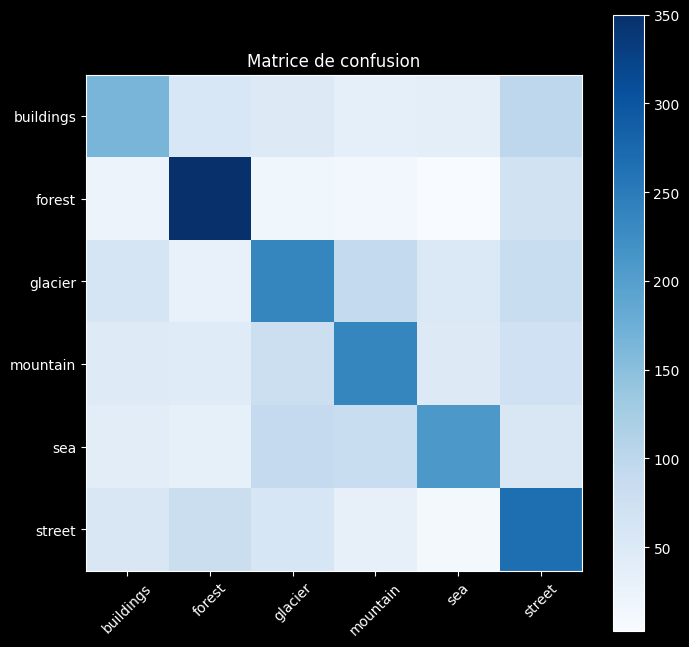

In [12]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,8))
plt.imshow(cm, cmap='Blues')
plt.title("Matrice de confusion")
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.yticks(range(len(class_names)), class_names)
plt.colorbar()
plt.show()


In [13]:
output_dir = "checkpoints_ORB"
os.makedirs(output_dir, exist_ok=True)

In [14]:
joblib.dump(svm, os.path.join(output_dir, "svm_bovw_orb_Intel.pkl"))
joblib.dump(kmeans, os.path.join(output_dir, "kmeans_vocab_Intel.pkl"))
print("Modèle sauvegardé")

Modèle sauvegardé


### CONCLUSION
Sur la base Intel Image, la méthode ORB + Bag of Visual Words + SVM atteint une accuracy d’environ 49 %. Ce résultat s’explique par la complexité du dataset et la forte similarité visuelle entre certaines classes. L’approche repose sur des descripteurs locaux et ne prend pas en compte la structure globale de la scène, ce qui limite ses performances. Néanmoins, le modèle reste stable, bien équilibré entre les classes, et offre une solution peu coûteuse permettant d’obtenir des performances significativement supérieures au hasard.